
Amazon review classification with BERT.[Download data from [this](https://www.kaggle.com/snap/amazon-fine-food-reviews/data) link]
<pre> 
It contains 5 parts as below.  Detailed instrctions are given in the each cell. 
    1. Preprocessing 
    2. Creating a BERT model from the Tensorflow HUB.
    3. Tokenization
    4. getting the pretrained embedding Vector for a given review from the BERT.
    5. Using the embedding data apply NN and classify the reviews.
    6. Creating a Data pipeline for BERT Model. 


</pre>

In [4]:
!wget --header="Host: doc-10-c4-docs.googleusercontent.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/83.0.0.0 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-US,en;q=0.9" --header="Referer: https://drive.google.com/drive/folders/1cSxMlj_KyUEK_3ZU609oFCTkYIMLwk6s" --header="Cookie: AUTH_qt52u2gu6qban90vehnie4dc20mth5n4_nonce=a109cvoqa2km2" --header="Connection: keep-alive" "https://doc-10-c4-docs.googleusercontent.com/docs/securesc/cpqrl8u0bfmm43paalnv6tsqiqd8at9v/4r06n4a4r3jkkck9jlv4i2e4p3u73837/1593761325000/18338633539012077285/03674084270746528232/1GsD8JlAc_0yJ-1151LNr6rLw83RRUPgt?e=download&authuser=0&nonce=a109cvoqa2km2&user=03674084270746528232&hash=9suidg7pr95uv0sg2r6fk2n8csfap1cr" -c -O 'Reviews.csv'

--2020-07-03 08:35:16--  https://doc-10-c4-docs.googleusercontent.com/docs/securesc/cpqrl8u0bfmm43paalnv6tsqiqd8at9v/4r06n4a4r3jkkck9jlv4i2e4p3u73837/1593761325000/18338633539012077285/03674084270746528232/1GsD8JlAc_0yJ-1151LNr6rLw83RRUPgt?e=download&authuser=0&nonce=a109cvoqa2km2&user=03674084270746528232&hash=9suidg7pr95uv0sg2r6fk2n8csfap1cr
Resolving doc-10-c4-docs.googleusercontent.com (doc-10-c4-docs.googleusercontent.com)... 74.125.133.132, 2a00:1450:400c:c07::84
Connecting to doc-10-c4-docs.googleusercontent.com (doc-10-c4-docs.googleusercontent.com)|74.125.133.132|:443... connected.
HTTP request sent, awaiting response... 403 Forbidden
2020-07-03 08:35:16 ERROR 403: Forbidden.



In [1]:
#all imports
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.models import Model
from tqdm import tqdm

In [2]:
tf.test.gpu_device_name()

'/device:GPU:0'

<pre><font size=6>Part-1: Preprocessing</font></pre>

In [5]:
#Read the dataset - Amazon fine food reviews
reviews = pd.read_csv('Reviews.csv')
#check the info of the dataset
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568438 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [6]:
#get only 2 columns - Text, Score
#drop the NAN values

In [7]:
data = pd.DataFrame()
data['Text'] = reviews['Text']
data['Score'] = reviews['Score']

In [8]:
data.isnull().any()

Text     False
Score    False
dtype: bool

In [9]:
#if score> 3, set score = 1
#if score<=2, set score = 0
#if score == 3, remove the rows. 

In [10]:
data.loc[data['Score']<3, 'Score'] = 0
data.loc[data['Score']>3, 'Score'] = 1

In [11]:
data = data.drop(data[data.Score ==3].index)

In [12]:
reviews = data

In [14]:
def get_wordlen(x):
    return len(x.split())
reviews['len'] = reviews.Text.apply(get_wordlen)
reviews = reviews[reviews.len<50]
reviews = reviews.sample(n=100000, random_state=30)

In [15]:
#remove HTML from the Text column and save in the Text column only
#code from https://stackoverflow.com/a/45999467/11913076

reviews.Text = reviews.Text.str.replace('<[^<]+?>', '')

In [16]:
#print head 5

reviews.head(5)

,Text,Score,len
64117,The tea was of great quality and it tasted lik...,1,30
418112,My cat loves this. The pellets are nice and s...,1,31
357829,Great product. Does not completely get rid of ...,1,41
175872,This gum is my favorite! I would advise every...,1,27
178716,I also found out about this product because of...,1,22


In [17]:
#split the data into train and test data(20%) with Stratify sampling, random state 33, 

from sklearn.model_selection import train_test_split

data = pd.DataFrame()
data['Score'] = reviews['Score']
reviews = reviews.drop(['Score'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(reviews, data, test_size=0.2, random_state=33, stratify=data)

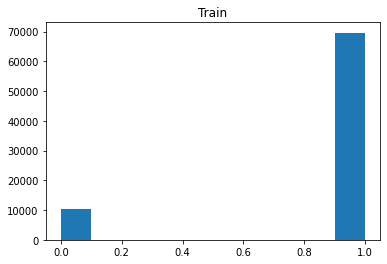

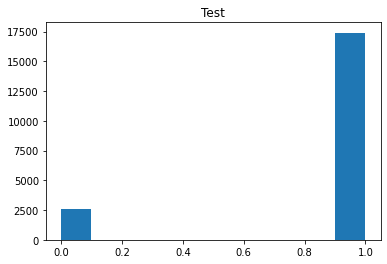

In [18]:
#plot bar graphs of y_train and y_test
import matplotlib.pyplot as plt
plt.hist(y_train.values)
plt.title('Train')
plt.show()
plt.hist(y_test.values)
plt.title('Test')
plt.show()


In [19]:
#saving to disk. if we need, we can load preprocessed data directly. 
reviews.to_csv('preprocessed.csv', index=False)

<pre><font size=6>Part-2: Creating BERT Model</font> 

If you want to know more about BERT, You can watch live sessions on Transformers and BERt. 
we will strongly recommend you to read <a href="https://jalammar.github.io/illustrated-transformer/">Transformers</a>, <a href="https://arxiv.org/abs/1810.04805">BERT Paper</a> and, <a href="https://jalammar.github.io/a-visual-guide-to-using-bert-for-the-first-time/">This blog</a>.


For this I amd using <a href="https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1">BERT uncased Base model</a>. 
It uses L=12 hidden layers (i.e., Transformer blocks), a hidden size of H=768, and A=12 attention heads. </pre>

In [20]:
for i in tqdm(range(len(X_train['Text']))):
  if i == 0:
    maxlen = len(X_train['Text'].iloc[i])
  elif len(X_train['Text'].iloc[i])>maxlen:
    maxlen = len(X_train['Text'].iloc[i])

100%|██████████| 80000/80000 [00:01<00:00, 65559.15it/s]


In [21]:
maxlen

410

In [22]:
## Loading the Pretrained Model from tensorflow HUB
tf.keras.backend.clear_session()

# maximum length of a seq in the data we have 
max_seq_length = 410

#BERT takes 3 inputs

#this is input words. Sequence of words represented as integers
input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_word_ids")

#mask vector if you are padding anything
input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_mask")

#segment vectors. If you are giving only one sentence for the classification, total seg vector is 0. 
#If you are giving two sentenced with [sep] token separated, first seq segment vectors are zeros and 
#second seq segment vector are 1's
segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="segment_ids")

#bert layer 
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2", trainable=False)    #updated pretrained model was available for bert so I used that
pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])

#Bert model
#We are using only pooled output not sequence out. 
#please read https://www.kaggle.com/questions-and-answers/86510
bert_model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=pooled_output)


In [23]:
bert_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 410)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 410)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 410)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

In [24]:
bert_model.output

<tf.Tensor 'keras_layer/Identity:0' shape=(None, 768) dtype=float32>

<pre><font size=6>Part-3: Tokenization</font></pre>

In [25]:
#getting Vocab file
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()

In [26]:
!pip install bert-for-tf2

     |████████████████████████████████| 40kB 2.9MB/s 
  Created wheel for bert-for-tf2: filename=bert_for_tf2-0.14.4-cp36-none-any.whl size=30114 sha256=c57dd5c4251c522eb627a4eac5c30589266ae1a1ac1f864221b84050604b1147
  Stored in directory: /root/.cache/pip/wheels/cf/3f/4d/79d7735015a5f523648df90d871ce8e89a7df8185f7703eeab
  Created wheel for py-params: filename=py_params-0.9.7-cp36-none-any.whl size=7302 sha256=5543fe06cc727803d9ee51f593a74b1f3aba83b4d8ddd7373b2d5ec41b7ba199
  Stored in directory: /root/.cache/pip/wheels/67/f5/19/b461849a50aefdf4bab47c4756596e82ee2118b8278e5a1980
  Created wheel for params-flow: filename=params_flow-0.8.2-cp36-none-any.whl size=19473 sha256=071570f8924f59e8a1147b0133e68c0c022ac29b418764ecfee65e48d5891f26
  Stored in directory: /root/.cache/pip/wheels/08/c8/7f/81c86b9ff2b86e2c477e3914175be03e679e596067dc630c06
Successfully built bert-for-tf2 py-params params-flow


In [27]:
#import tokenization - We have given tokenization.py file
from bert import bert_tokenization

In [28]:
# Create tokenizer " Instantiate FullTokenizer" 
# name must be "tokenizer"

tokenizer = bert_tokenization.FullTokenizer(bert_layer.resolved_object.vocab_file.asset_path.numpy(),bert_layer.resolved_object.do_lower_case.numpy())


In [30]:
# Create train and test tokens (X_train_tokens, X_test_tokens) from (X_train, X_test) using Tokenizer and 

sentences_train = [sentence for sentence in tqdm(X_train['Text'])]
sentences_test = [sentence for sentence in tqdm(X_test['Text'])]

X_train_tokens = [tokenizer.tokenize(sentence) for sentence in tqdm(sentences_train)]
X_test_tokens = [tokenizer.tokenize(sentence) for sentence in tqdm(sentences_test)]

100%|██████████| 20000/20000 [00:11<00:00, 1778.44it/s]


In [31]:
# add '[CLS]' at start of the Tokens and '[SEP]' at the end of the tokens. 

for i in tqdm(range(len(X_train_tokens))):
    X_train_tokens[i].insert(0,"[CLS]")
    X_train_tokens[i].append("[SEP]")

for i in tqdm(range(len(X_test_tokens))):
    X_test_tokens[i].insert(0,"[CLS]")
    X_test_tokens[i].append("[SEP]")

100%|██████████| 20000/20000 [00:00<00:00, 988499.92it/s]


In [32]:
X_train_tokens_ = []
X_test_tokens_ = []

for i in tqdm(X_train_tokens):
    X_train_tokens_.append(tokenizer.convert_tokens_to_ids(i))
for i in tqdm(X_test_tokens):
    X_test_tokens_.append(tokenizer.convert_tokens_to_ids(i))

100%|██████████| 20000/20000 [00:00<00:00, 102369.76it/s]


In [33]:
X_train_tokens = X_train_tokens_
X_test_tokens = X_test_tokens_

In [34]:
for i in tqdm(range(len(X_train_tokens))):
    if i == 0:
        maxlen = len(X_train_tokens[i])
    else:
        if maxlen<len(X_train_tokens[i]):
            maxlen = len(X_train_tokens[i])

maxlen

100%|██████████| 80000/80000 [00:00<00:00, 1620822.62it/s]


189

In [35]:
# maximum number of tokens is 410(We already given this to BERT layer above) so shape is (None, 410)

# if it is less than 410, add '[PAD]' token else truncate the tokens length.(similar to padding)

for i in tqdm(range(len(X_train_tokens))):
    while len(X_train_tokens[i])<410:
        X_train_tokens[i].append("[PAD]")

for i in tqdm(range(len(X_test_tokens))):
    while len(X_test_tokens[i])<410:
        X_test_tokens[i].append("[PAD]")

100%|██████████| 20000/20000 [00:01<00:00, 10784.85it/s]


In [36]:
# Based on padding, create the mask for Train and Test ( 1 for real token, 0 for '[PAD]'), 

X_train_mask = []
X_test_mask = []

for i in tqdm(X_train_tokens):
    X_train_mask_temp = []
    for j in i:
        if j!="[PAD]":
           X_train_mask_temp.append(1)
        else:
           X_train_mask_temp.append(0)
    X_train_mask.append(X_train_mask_temp)

for i in tqdm(X_test_tokens):
    X_test_mask_temp  = []
    for j in i:
        if j!="[PAD]":
            X_test_mask_temp.append(1)
        else:
            X_test_mask_temp.append(0)
    X_test_mask.append(X_test_mask_temp)

100%|██████████| 20000/20000 [00:01<00:00, 15639.35it/s]


In [37]:
# it will also same shape as input tokens (None, 410) save those in X_train_mask, X_test_mask

# Create a segment input for train and test. We are using only one sentence so all zeros. This shape will also (None, 410)
X_train_segment = []
X_test_segment = []

for i in tqdm(X_train_tokens):
    X_train_seg_temp = []
    for j in i:
        X_train_seg_temp.append(0)
    X_train_segment.append(X_train_seg_temp)

for i in tqdm(X_test_tokens):
    X_test_seg_temp = []
    for j in i:
        X_test_seg_temp.append(0)
    X_test_segment.append(X_test_seg_temp)

100%|██████████| 20000/20000 [00:00<00:00, 22071.67it/s]


In [38]:
for i in tqdm(range(len(X_train_tokens))):
    for j in range(len(X_train_tokens[i])):
        if X_train_tokens[i][j]=="[PAD]":
           X_train_tokens[i][j] = 0

for i in tqdm(range(len(X_test_tokens))):
    for j in range(len(X_test_tokens[i])):
        if X_test_tokens[i][j]=="[PAD]":
           X_test_tokens[i][j] = 0

100%|██████████| 20000/20000 [00:01<00:00, 11320.48it/s]


In [39]:
# type of all the above arrays should be numpy arrays
X_train_tokens = np.asarray(X_train_tokens)
X_test_tokens = np.asarray(X_test_tokens)

X_train_mask = np.asarray(X_train_mask)
X_test_mask = np.asarray(X_test_mask)

X_train_segment = np.asarray(X_train_segment)
X_test_segment = np.asarray(X_test_segment)

In [41]:
import pickle

In [42]:
##save all your results to disk so that, no need to run all again. 
pickle.dump((X_train, X_train_tokens, X_train_mask, X_train_segment, y_train),open('train_data.pkl','wb'))
pickle.dump((X_test, X_test_tokens, X_test_mask, X_test_segment, y_test),open('test_data.pkl','wb'))

In [43]:
#you can load from disk
X_train, X_train_tokens, X_train_mask, X_train_segment, y_train = pickle.load(open("train_data.pkl", 'rb')) 
X_test, X_test_tokens, X_test_mask, X_test_segment, y_test = pickle.load(open("test_data.pkl", 'rb')) 

<pre><font size=6>Part-4: Getting Embeddings from BERT Model</font>
We already created the BERT model in the part-2 and input data in the part-3. 
We will utlize those two and will get the embeddings for each sentence in the 
Train and test data.</pre>

In [46]:
bert_model.input

[<tf.Tensor 'input_word_ids:0' shape=(None, 410) dtype=int32>,
 <tf.Tensor 'input_mask:0' shape=(None, 410) dtype=int32>,
 <tf.Tensor 'segment_ids:0' shape=(None, 410) dtype=int32>]

In [47]:
bert_model.output

<tf.Tensor 'keras_layer/Identity:0' shape=(None, 768) dtype=float32>

In [48]:
# get the train output, BERT model will give one output so save in
# X_train_pooled_output

import time
t0= time.clock()

X_train_pooled_output=bert_model.predict([X_train_tokens,X_train_mask,X_train_segment])

t1 = time.clock() - t0
print(t1)

5554.036447


In [49]:
# get the test output, BERT model will give one output so save in
# X_test_pooled_output

import time
t0= time.clock()

X_test_pooled_output=bert_model.predict([X_test_tokens,X_test_mask,X_test_segment])

t1 = time.clock() - t0
print(t1)

1380.9508959999994


In [51]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [100]:
##save all your results to disk so that, no need to run all again. 
pickle.dump((X_train_pooled_output, X_test_pooled_output, y_train, y_test),open('drive/My Drive/Saved Pickles/BERT/final_output.pkl','wb'))

In [101]:
import pickle
X_train_pooled_output, X_test_pooled_output, y_train, y_test= pickle.load(open('drive/My Drive/Saved Pickles/BERT/final_output.pkl', 'rb'))

In [114]:
y_train = y_train.ravel()
y_test = y_test.ravel()

In [103]:
X_train = X_train_pooled_output
X_test = X_test_pooled_output

<pre><font size=6>Part-5: Training a NN with 768 features</font>

In [167]:
y_train_ = tf.keras.utils.to_categorical(y_train,2)
y_test_ = tf.keras.utils.to_categorical(y_test,2)

In [168]:
##imports
from tensorflow.keras.layers import Input, Dense, Activation, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dense,Input,Conv2D,MaxPool2D,Activation,Dropout,Flatten, concatenate

In [378]:
##create an NN and 
tf.keras.backend.clear_session()
input_Layera = Input(shape=(768),name='Input_Layera')
Dense_layera = Dense(units=50,activation='relu',kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.1),name = 'Dense_layera')(input_Layera)
Dropout_layera = Dropout(rate=0.1, name='Dropout_layera')(Dense_layera)

Dense_layerb = Dense(units=50,activation='relu',kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.1),name = 'Dense_layerb')(Dropout_layera)
Dropout_layerb = Dropout(rate=0.1, name='Dropout_layerb')(Dense_layerb)

Dense_layerc = Dense(units=50,activation='relu',kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.1),name = 'Dense_layerc')(Dropout_layerb)
Dropout_layerc = Dropout(rate=0.1, name='Dropout_layerc')(Dense_layerc)

Dense_layer1 = Dense(units=50,activation='relu',kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.1),name = 'Dense_layer1')(Dropout_layerc)
Dropout_layer1 = Dropout(rate=0.1, name='Dropout_layer1')(Dense_layer1)

Dense_layer2 = Dense(units=60,activation='relu',kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.1),name = 'Dense_layer2')(Dropout_layer1)
Dropout_layer2 = Dropout(rate=0.1, name='Dropout_layer2')(Dense_layer2)

Dense_layer3 = Dense(units=30,activation='relu',kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.1),name = 'Dense_layer3')(Dropout_layer2)

Out = Dense(units=2,activation='softmax',kernel_initializer=tf.keras.initializers.glorot_normal(seed=3),name='Output')(Dense_layer3)

model = Model(inputs=input_Layera,outputs=Out)

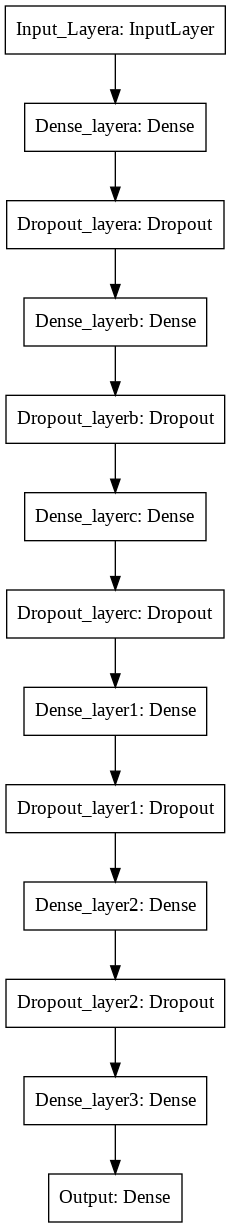

In [379]:
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=False, show_layer_names=True,
    rankdir='TB', expand_nested=False, dpi=96
)

In [380]:
neg, pos = np.bincount(y_train)
total = neg + pos
print('Total: {}\n    Positive: {} ({:.2f}% of total)'.format(
    total, pos, 100 * pos / total))

Total: 80000
    Positive: 69603 (87.00% of total)


In [381]:
weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 3.85
Weight for class 1: 0.57


In [382]:
# code from https://stackoverflow.com/a/49830391/11913076

from sklearn.metrics import roc_auc_score
import tensorflow as tf
def auc( y_true, y_pred ) :
    score = tf.compat.v1.py_func( roc_auc_score, (y_true,y_pred), tf.double)
    return score

In [383]:
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.01),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=auc)

In [384]:
model.fit(X_train,y_train_,batch_size=100, epochs=50, 
          validation_data=(X_test, y_test_), class_weight=class_weight)

Epoch 1/50
800/800 [==============================] - 7s 8ms/step - loss: 2.8346 - auc: 0.6378 - val_loss: 1.9219 - val_auc: 0.8224
Epoch 2/50
800/800 [==============================] - 6s 8ms/step - loss: 1.4530 - auc: 0.7975 - val_loss: 1.3928 - val_auc: 0.8788
Epoch 3/50
800/800 [==============================] - 6s 8ms/step - loss: 0.8970 - auc: 0.8824 - val_loss: 0.6909 - val_auc: 0.9208
Epoch 4/50
800/800 [==============================] - 6s 8ms/step - loss: 0.6701 - auc: 0.9110 - val_loss: 0.6463 - val_auc: 0.9340
Epoch 5/50
800/800 [==============================] - 6s 8ms/step - loss: 0.5797 - auc: 0.9238 - val_loss: 0.7299 - val_auc: 0.9362
Epoch 6/50
800/800 [==============================] - 6s 8ms/step - loss: 0.5295 - auc: 0.9296 - val_loss: 0.4016 - val_auc: 0.9419
Epoch 7/50
800/800 [==============================] - 6s 8ms/step - loss: 0.5033 - auc: 0.9338 - val_loss: 0.5622 - val_auc: 0.9438
Epoch 8/50
800/800 [==============================] - 6s 8ms/step - loss: 0.

# Model summary:
    
                |   Max AUC    |    Min Loss    |
        Train   |    0.9539    |     0.3915     |
        Test    |    0.9567    |     0.3275     |

In [289]:
!wget --header="Host: doc-10-14-docs.googleusercontent.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/83.0.0.0 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-US,en;q=0.9" --header="Referer: https://drive.google.com/" --header="Cookie: AUTH_qt52u2gu6qban90vehnie4dc20mth5n4_nonce=qj208lpsu2rc4" --header="Connection: keep-alive" "https://doc-10-14-docs.googleusercontent.com/docs/securesc/cpqrl8u0bfmm43paalnv6tsqiqd8at9v/11f2qfhk3i6tlcurp13lqktu7nl4fnu4/1593779700000/00484516897554883881/03674084270746528232/1QwjqTsqTX2vdy7fTmeXjxP3dq8IAVLpo?e=download&authuser=0&nonce=qj208lpsu2rc4&user=03674084270746528232&hash=adunag0erqtmdt4duio64mde9ipehpug" -c -O 'test.csv'

--2020-07-03 12:37:32--  https://doc-10-14-docs.googleusercontent.com/docs/securesc/cpqrl8u0bfmm43paalnv6tsqiqd8at9v/11f2qfhk3i6tlcurp13lqktu7nl4fnu4/1593779700000/00484516897554883881/03674084270746528232/1QwjqTsqTX2vdy7fTmeXjxP3dq8IAVLpo?e=download&authuser=0&nonce=qj208lpsu2rc4&user=03674084270746528232&hash=adunag0erqtmdt4duio64mde9ipehpug
Resolving doc-10-14-docs.googleusercontent.com (doc-10-14-docs.googleusercontent.com)... 74.125.133.132, 2a00:1450:400c:c07::84
Connecting to doc-10-14-docs.googleusercontent.com (doc-10-14-docs.googleusercontent.com)|74.125.133.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 62100 (61K) [text/csv]
Saving to: ‘test.csv’

test.csv            100%[===================>]  60.64K  --.-KB/s    in 0.001s  

2020-07-03 12:37:32 (60.6 MB/s) - ‘test.csv’ saved [62100/62100]



<Pre><font size=6>Part-6: Creating a Data pipeline for BERT Model</font> 

1. Download data from <a href="https://drive.google.com/file/d/1QwjqTsqTX2vdy7fTmeXjxP3dq8IAVLpo/view?usp=sharing">here</a>
2. Read the csv file
3. Remove all the html tags
4. Now do tokenization [Part 3 as mentioned above]
    * Create tokens,mask array and segment array
5. Get Embeddings from BERT Model [Part 4 as mentioned above] , let it be X_test
   * Print the shape of output(X_test.shape).You should get (352,768)
6. Predit the output of X_test with the Neural network model which we trained earlier.
7. Print the occurences of class labels in the predicted output

</pre>

In [387]:
def pipeline(X_):
  print('Preprocessing...\n')
  
  #X_ = pd.read_csv('test.csv') 

  X_.Text = X_.Text.str.replace('<[^<]+?>', '')

  print('Creating tokens...\n')
  sentences = [sentence for sentence in (X_.Text)]
  tokens = [tokenizer.tokenize(sentence) for sentence in (sentences)]

  for i in (range(len(tokens))):
    tokens[i].insert(0,"[CLS]")
    tokens[i].append("[SEP]")

  tokens_ = []
  for i in (tokens):
    tokens_.append(tokenizer.convert_tokens_to_ids(i))

  tokens = tokens_
  for i in (range(len(tokens))):
    while len(tokens[i])<410:
        tokens[i].append("[PAD]")

  print('Creating masks...\n')
  mask = []

  for i in (tokens):
    mask_temp = []
    for j in i:
        if j!="[PAD]":
           mask_temp.append(1)
        else:
           mask_temp.append(0)
    mask.append(mask_temp)

  print('Creating segments...\n')
  segment = []

  for i in (tokens):
    seg_temp = []
    for j in i:
        seg_temp.append(0)
    segment.append(seg_temp)

  for i in (range(len(tokens))):
    for j in range(len(tokens[i])):
        if tokens[i][j]=="[PAD]":
           tokens[i][j] = 0

  tokens = np.asarray(tokens)

  mask = np.asarray(mask)

  segment = np.asarray(segment)

  print('Getting embeddings from BERT...\n')
  pooled_output=bert_model.predict([tokens,mask,segment])

  X_ = pooled_output

  print('Shape of test:',X_.shape)

  predictions = model.predict(X_)

  zeros = 0
  ones = 0

  for i in predictions:
    if i[0]>=0.5:
      zeros+=1
    else:
      ones+=1

  print('\nPredictions summary:\n \t Number of zeros : {} \n \t Number of ones : {}'.format(str(zeros),str(ones)))

In [390]:
test = pd.read_csv('test.csv')
pipeline(test)

Preprocessing...

Creating tokens...

Creating masks...

Creating segments...

Getting embeddings from BERT...

Shape of test: (352, 768)

Predictions summary:
 	 Number of zeros : 89 
 	 Number of ones : 263
